### This notebook provides details of finetuning the sentence embedding model

In this notebook, I compared two well known sentence embedding models: 
- MiniLM
- BAAI

I further finetuned them simply using the data I generated with the help of gpt 3.5 turbo. Below is the detail of how I generated the dataset for finetune sentence embedding models:

First, I made a dataset to fine-tune the embedding models and then picked the best one. Here’s how I made the data:
1. I combined two datasets. For the first part, I asked the model to create a question from a chunk of text. Then, I made positive pairs using the question and the chunk itself.
2. For the second part, I used GPT-3.5 Turbo to create a question for each chunk of text. Then, I asked GPT-3.5 again to find sentences that answer the question, creating a question and anchor pair.

Finally, I concatenated these two datasets. I did this make sure the embedding models learn to associate questions with relevant answers, enhancing their performance in understanding and retrieving information based on the given dataset. Now, I have both postive pairs and negative example which can be used to finetune these models.

I had two approaches for finetuning the models:
1. Finetune the model itself without projection laeyer + norm
2. Finetune by adding a dense layer (keep dim to be the same original one) + L2 projection layer as the final layer for the embedding model, and start training model for 5 epochs. In this way, cosine similarity is more meaningful and l2 norm of embeddings is 1. 



In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer, InputExample, losses
from sentence_transformers.evaluation import InformationRetrievalEvaluator, SequentialEvaluator
from torch.utils.data import DataLoader
from datasets import load_dataset, concatenate_datasets
from tqdm.autonotebook import tqdm, trange
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import faiss
from typing import List, Tuple


/home/alilotfi/anaconda3/envs/myenv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-07-08 10:18:26.634815: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-08 10:18:27.587850: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# loading couple of dataset created with openai - gpt 3.5
df_extract_0 = pd.read_csv("finetune_dataset/dataset_0.csv")
df_extract_1 = pd.read_csv("finetune_dataset/dataset_1.csv")
df_extract_2 = pd.read_csv("finetune_dataset/dataset_2.csv")
df_chunk = pd.read_csv("finetune_dataset/dataset_embedding.csv")

df_concat = pd.concat([df_extract_0, df_extract_1, df_extract_2, df_chunk], axis=0)

In [3]:

# spliting the training data for embeddings to train and test
#df = pd.read_csv('finetune_dataset/dataset_embedding.csv')  

train_df, test_df = train_test_split(df_concat, test_size=0.2, random_state=40)
train_df.to_csv("finetune_dataset/train_embedding.csv", index=False)
test_df.to_csv("finetune_dataset/test_embedding.csv", index=False)


In [4]:
test_data = pd.read_csv("finetune_dataset/test_embedding.csv")

In [5]:
queries = {i: col for i, col in enumerate(test_data["Question"].tolist())}
corpus = {i: col for i, col in enumerate(test_data["Context"].tolist())}
relevant_docs = {i: [i] for i in range(len(test_data))}
ir_evaluator = InformationRetrievalEvaluator(queries, corpus, relevant_docs)
evaluator = SequentialEvaluator([ir_evaluator])

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_baai = SentenceTransformer("BAAI/bge-base-en-v1.5", device=device)
results_baai = evaluator(model_baai)

print("Evaluation Results_baai")
print(results_baai)


/home/alilotfi/anaconda3/envs/myenv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Evaluation Results_baai
{'cosine_accuracy@1': 0.7728785357737105, 'cosine_accuracy@3': 0.8452579034941764, 'cosine_accuracy@5': 0.8652246256239601, 'cosine_accuracy@10': 0.8835274542429284, 'cosine_precision@1': 0.7728785357737105, 'cosine_precision@3': 0.28175263449805876, 'cosine_precision@5': 0.17304492512479203, 'cosine_precision@10': 0.08835274542429285, 'cosine_recall@1': 0.7728785357737105, 'cosine_recall@3': 0.8452579034941764, 'cosine_recall@5': 0.8652246256239601, 'cosine_recall@10': 0.8835274542429284, 'cosine_ndcg@10': 0.831216046665873, 'cosine_mrr@10': 0.8142408155719305, 'cosine_map@100': 0.8181773316197641, 'dot_accuracy@1': 0.7728785357737105, 'dot_accuracy@3': 0.8452579034941764, 'dot_accuracy@5': 0.8652246256239601, 'dot_accuracy@10': 0.8835274542429284, 'dot_precision@1': 0.7728785357737105, 'dot_precision@3': 0.28175263449805876, 'dot_precision@5': 0.17304492512479203, 'dot_precision@10': 0.08835274542429285, 'dot_recall@1': 0.7728785357737105, 'dot_recall@3': 0.84

In [7]:
model_mini = SentenceTransformer('all-MiniLM-L6-v2', device=device)

results_minilm = evaluator(model_mini)

print("Evaluation Results_minilm")
print(results_minilm)

Evaluation Results_minilm
{'cosine_accuracy@1': 0.7154742096505824, 'cosine_accuracy@3': 0.8227953410981698, 'cosine_accuracy@5': 0.8427620632279534, 'cosine_accuracy@10': 0.8752079866888519, 'cosine_precision@1': 0.7154742096505824, 'cosine_precision@3': 0.27426511369938994, 'cosine_precision@5': 0.16855241264559068, 'cosine_precision@10': 0.0875207986688852, 'cosine_recall@1': 0.7154742096505824, 'cosine_recall@3': 0.8227953410981698, 'cosine_recall@5': 0.8427620632279534, 'cosine_recall@10': 0.8752079866888519, 'cosine_ndcg@10': 0.7988421958353669, 'cosine_mrr@10': 0.7741257956316194, 'cosine_map@100': 0.7781532806165314, 'dot_accuracy@1': 0.7154742096505824, 'dot_accuracy@3': 0.8227953410981698, 'dot_accuracy@5': 0.8427620632279534, 'dot_accuracy@10': 0.8752079866888519, 'dot_precision@1': 0.7154742096505824, 'dot_precision@3': 0.27426511369938994, 'dot_precision@5': 0.16855241264559068, 'dot_precision@10': 0.0875207986688852, 'dot_recall@1': 0.7154742096505824, 'dot_recall@3': 0.8

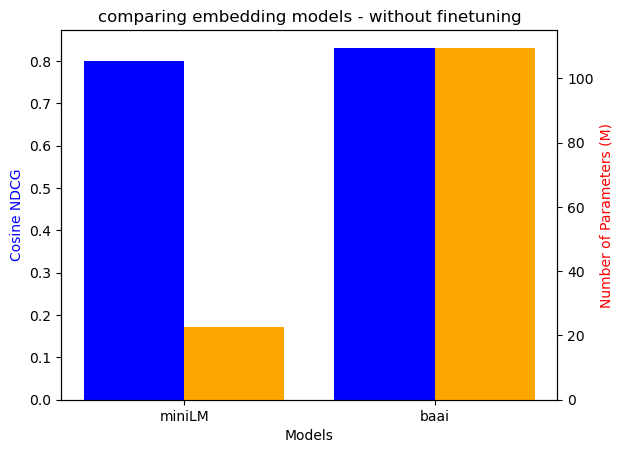

In [8]:
# Comparing two models against each other in terms of number of parameters and also cosine normalized discounted cumulative gain

import matplotlib.pyplot as plt

models = ["miniLM", "baai"]
mini_lm_ndcg = results_minilm['cosine_ndcg@10']
baai_lm_ndcg = results_baai['cosine_ndcg@10']

mini_params = sum(p.numel() for p in model_mini.parameters())/1000000.0
baai_params = sum(p.numel() for p in model_baai.parameters())/1000000.0

cosine_ncdg = [mini_lm_ndcg, baai_lm_ndcg] 
num_parameters = [mini_params, baai_params]  


x = np.arange(len(models)) 

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.bar(x - 0.2, cosine_ncdg, width=0.4, label='Cosine NDCG', color='blue', align='center')
ax2.bar(x + 0.2, num_parameters, width=0.4, label='Number of Parameters (M)', color='orange', align='center')


ax1.set_xlabel('Models')
ax1.set_ylabel('Cosine NDCG', color='b')
ax2.set_ylabel('Number of Parameters (M)', color='r')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_title('comparing embedding models - without finetuning')

plt.show()



The SimCLR loss for contrastive learning for sentence embeddings is defined as follows:

L_SimCLR = -log[ exp(sim(h_i, h_j) / τ) / Σ(k=1 to 2N) 1[k ≠ i] * exp(sim(h_i, h_k) / τ) ]

Where:
- h_i and h_j are the embeddings of the positive pair.
- sim(h_i, h_j) is the cosine similarity between h_i and h_j.
- τ (tau) is a temperature parameter.
- 2N is the total number of samples in the batch.
- 1[k ≠ i] is an indicator function equal to 1 if k ≠ i, otherwise 0.

In [17]:
train_data = pd.read_csv("finetune_dataset/train_embedding.csv")

#curing data for finetuning the embedding model
train = []
for _, row in train_data.iterrows():
    train.append(InputExample(texts=[row['Question'], row['Context']]))

train_dataloader = DataLoader(train, shuffle=True, batch_size=16)
train_loss = losses.MultipleNegativesRankingLoss(model_baai)

model_baai.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=3,
    warmup_steps=100,
    output_path='baai_finetuned'
)



Currently using DataParallel (DP) for multi-gpu training, while DistributedDataParallel (DDP) is recommended for faster training. See https://sbert.net/docs/sentence_transformer/training/distributed.html for more information.


Step,Training Loss
500,0.030600


In [10]:
train_dataloader = DataLoader(train, shuffle=True, batch_size=16)
train_loss = losses.MultipleNegativesRankingLoss(model_mini)
# train mini lm 
model_mini.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=3,
    warmup_steps=100,
    output_path='minilm_finetuned'
)


Currently using DataParallel (DP) for multi-gpu training, while DistributedDataParallel (DDP) is recommended for faster training. See https://sbert.net/docs/sentence_transformer/training/distributed.html for more information.


Step,Training Loss
500,0.080300


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_baai_finetuned = SentenceTransformer("baai_finetuned", device=device)
results_baai_finetuned = evaluator(model_baai_finetuned)

print("Finetuned --> Evaluation Results_baai ")
print(results_baai_finetuned)

Finetuned --> Evaluation Results_baai 
{'cosine_accuracy@1': 0.8194675540765392, 'cosine_accuracy@3': 0.8868552412645591, 'cosine_accuracy@5': 0.9101497504159733, 'cosine_accuracy@10': 0.9317803660565723, 'cosine_precision@1': 0.8194675540765392, 'cosine_precision@3': 0.29561841375485304, 'cosine_precision@5': 0.18202995008319467, 'cosine_precision@10': 0.09317803660565722, 'cosine_recall@1': 0.8194675540765392, 'cosine_recall@3': 0.8868552412645591, 'cosine_recall@5': 0.9101497504159733, 'cosine_recall@10': 0.9317803660565723, 'cosine_ndcg@10': 0.8762154559471228, 'cosine_mrr@10': 0.8583604046166446, 'cosine_map@100': 0.8613820928698299, 'dot_accuracy@1': 0.8194675540765392, 'dot_accuracy@3': 0.8868552412645591, 'dot_accuracy@5': 0.9101497504159733, 'dot_accuracy@10': 0.9317803660565723, 'dot_precision@1': 0.8194675540765392, 'dot_precision@3': 0.29561841375485304, 'dot_precision@5': 0.18202995008319467, 'dot_precision@10': 0.09317803660565722, 'dot_recall@1': 0.8194675540765392, 'dot

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_minilm_finetuned = SentenceTransformer("minilm_finetuned/", device=device)
results_minilm_finetuned = evaluator(model_minilm_finetuned)

print("Finetuned --> Evaluation Results_minilm ")
print(results_minilm_finetuned)

Finetuned --> Evaluation Results_minilm 
{'cosine_accuracy@1': 0.8086522462562395, 'cosine_accuracy@3': 0.8810316139767055, 'cosine_accuracy@5': 0.8976705490848585, 'cosine_accuracy@10': 0.9201331114808652, 'cosine_precision@1': 0.8086522462562395, 'cosine_precision@3': 0.29367720465890185, 'cosine_precision@5': 0.1795341098169717, 'cosine_precision@10': 0.09201331114808652, 'cosine_recall@1': 0.8086522462562395, 'cosine_recall@3': 0.8810316139767055, 'cosine_recall@5': 0.8976705490848585, 'cosine_recall@10': 0.9201331114808652, 'cosine_ndcg@10': 0.8657980069668284, 'cosine_mrr@10': 0.8483166283707051, 'cosine_map@100': 0.8519488676633085, 'dot_accuracy@1': 0.8086522462562395, 'dot_accuracy@3': 0.8810316139767055, 'dot_accuracy@5': 0.8976705490848585, 'dot_accuracy@10': 0.9201331114808652, 'dot_precision@1': 0.8086522462562395, 'dot_precision@3': 0.29367720465890185, 'dot_precision@5': 0.1795341098169717, 'dot_precision@10': 0.09201331114808652, 'dot_recall@1': 0.8086522462562395, 'dot

In [12]:
import pandas as pd
from sentence_transformers import SentenceTransformer, InputExample, models, losses
from torch.utils.data import DataLoader
import torch
import torch.nn as nn


class ProjectionLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(ProjectionLayer, self).__init__()
        self.dense = nn.Linear(in_dim, out_dim)
    
    def forward(self, x):
        x = self.dense(x)
        x = nn.functional.normalize(x, p=2, dim=1)  # L2 normalization
        return x
        
model_baai_finetuned_projected = SentenceTransformer("BAAI/bge-base-en-v1.5", device=device)

projection_layer = ProjectionLayer(
    in_dim=model_baai_finetuned_projected.get_sentence_embedding_dimension(),
    out_dim=model_baai_finetuned_projected.get_sentence_embedding_dimension()
)

model_baai_finetuned_projected._first_module().auto_model.add_module("projection_layer", projection_layer)
train_loss = losses.MultipleNegativesRankingLoss(model_baai_finetuned_projected)

model_baai_finetuned_projected.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=3,
    warmup_steps=100,
    output_path="baai_model_finetuned_projected"
)

torch.save(model_baai_finetuned_projected.state_dict(), "baai_model_finetuned_projected/model_state_dict.pt")

/home/alilotfi/anaconda3/envs/myenv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Currently using DataParallel (DP) for multi-gpu training, while DistributedDataParallel (DDP) is recommended for faster training. See https://sbert.net/docs/sentence_transformer/training/distributed.html for more information.


Step,Training Loss
500,0.082800


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

In [13]:
import pandas as pd
from sentence_transformers import SentenceTransformer, InputExample, models, losses
from torch.utils.data import DataLoader
import torch
import torch.nn as nn


class ProjectionLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(ProjectionLayer, self).__init__()
        self.dense = nn.Linear(in_dim, out_dim)
    
    def forward(self, x):
        x = self.dense(x)
        x = nn.functional.normalize(x, p=2, dim=1)  # L2 normalization
        return x
        
model_minilm_finetuned_projected = SentenceTransformer('all-MiniLM-L6-v2', device=device)

projection_layer = ProjectionLayer(
    in_dim=model_minilm_finetuned_projected.get_sentence_embedding_dimension(),
    out_dim=model_minilm_finetuned_projected.get_sentence_embedding_dimension()
)

model_minilm_finetuned_projected._first_module().auto_model.add_module("projection_layer", projection_layer)

train_loss = losses.MultipleNegativesRankingLoss(model_minilm_finetuned_projected)

# Train the model
model_minilm_finetuned_projected.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=3,
    warmup_steps=100,
    output_path="mini_model_finetuned_projected"
)

torch.save(model_minilm_finetuned_projected.state_dict(), "mini_model_finetuned_projected/model_state_dict.pt")

/home/alilotfi/anaconda3/envs/myenv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Currently using DataParallel (DP) for multi-gpu training, while DistributedDataParallel (DDP) is recommended for faster training. See https://sbert.net/docs/sentence_transformer/training/distributed.html for more information.


Step,Training Loss
500,0.078900


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

In [14]:
model_baai_finetuned_projected = SentenceTransformer("BAAI/bge-base-en-v1.5", device=device)
projection_layer = ProjectionLayer(
    in_dim=model_baai_finetuned_projected.get_sentence_embedding_dimension(),
    out_dim=model_baai_finetuned_projected.get_sentence_embedding_dimension()
)
model_baai_finetuned_projected._first_module().auto_model.add_module("projection_layer", projection_layer)
model_baai_finetuned_projected.load_state_dict(torch.load("baai_model_finetuned_projected/model_state_dict.pt"))

# Now evaluate the model
results_baai_finetuned_projected = evaluator(model_baai_finetuned_projected)

print("Finetuned & Dense Layer + Projection  --> Evaluation Results_baai ")
print(results_baai_finetuned_projected)

/home/alilotfi/anaconda3/envs/myenv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Finetuned & Dense Layer + Projection  --> Evaluation Results_baai 
{'cosine_accuracy@1': 0.8244592346089851, 'cosine_accuracy@3': 0.8935108153078203, 'cosine_accuracy@5': 0.9059900166389351, 'cosine_accuracy@10': 0.930116472545757, 'cosine_precision@1': 0.8244592346089851, 'cosine_precision@3': 0.2978369384359401, 'cosine_precision@5': 0.181198003327787, 'cosine_precision@10': 0.0930116472545757, 'cosine_recall@1': 0.8244592346089851, 'cosine_recall@3': 0.8935108153078203, 'cosine_recall@5': 0.9059900166389351, 'cosine_recall@10': 0.930116472545757, 'cosine_ndcg@10': 0.8787742397695537, 'cosine_mrr@10': 0.8622916831735472, 'cosine_map@100': 0.865488263389659, 'dot_accuracy@1': 0.8244592346089851, 'dot_accuracy@3': 0.8935108153078203, 'dot_accuracy@5': 0.9059900166389351, 'dot_accuracy@10': 0.930116472545757, 'dot_precision@1': 0.8244592346089851, 'dot_precision@3': 0.2978369384359401, 'dot_precision@5': 0.181198003327787, 'dot_precision@10': 0.0930116472545757, 'dot_recall@1': 0.824459

In [15]:
model_minilm_finetuned_projected = SentenceTransformer("all-MiniLM-L6-v2", device=device)
projection_layer = ProjectionLayer(
    in_dim=model_minilm_finetuned_projected.get_sentence_embedding_dimension(),
    out_dim=model_minilm_finetuned_projected.get_sentence_embedding_dimension()
)
model_minilm_finetuned_projected._first_module().auto_model.add_module("projection_layer", projection_layer)
model_minilm_finetuned_projected.load_state_dict(torch.load("mini_model_finetuned_projected/model_state_dict.pt"))

# Now evaluate the model
results_minilm_finetuned_projected = evaluator(model_minilm_finetuned_projected)

print("Finetuned & Dense Layer + Projection  --> Evaluation Results_minilm ")
print(results_minilm_finetuned_projected)

Finetuned & Dense Layer + Projection  --> Evaluation Results_minilm 
{'cosine_accuracy@1': 0.8153078202995009, 'cosine_accuracy@3': 0.8793677204658902, 'cosine_accuracy@5': 0.9009983361064892, 'cosine_accuracy@10': 0.9267886855241264, 'cosine_precision@1': 0.8153078202995009, 'cosine_precision@3': 0.29312257348863, 'cosine_precision@5': 0.18019966722129782, 'cosine_precision@10': 0.09267886855241264, 'cosine_recall@1': 0.8153078202995009, 'cosine_recall@3': 0.8793677204658902, 'cosine_recall@5': 0.9009983361064892, 'cosine_recall@10': 0.9267886855241264, 'cosine_ndcg@10': 0.8706078104065185, 'cosine_mrr@10': 0.8526595885164938, 'cosine_map@100': 0.8556762795811215, 'dot_accuracy@1': 0.8153078202995009, 'dot_accuracy@3': 0.8793677204658902, 'dot_accuracy@5': 0.9009983361064892, 'dot_accuracy@10': 0.9267886855241264, 'dot_precision@1': 0.8153078202995009, 'dot_precision@3': 0.29312257348863, 'dot_precision@5': 0.18019966722129782, 'dot_precision@10': 0.09267886855241264, 'dot_recall@1': 

## Mean Reciprocal Rank  mrr@10

it measures how quickly the first relevant result appears within the top 10 results, therefore, emphasizing early retrieval of relevant documents.

## Normalized Discounted Cumulative Gain (NDCG) @10 with cosine similarity

it measures the quality of the ranking by considering both the relevance and position of results within the top 10, using cosine similarity to measure relevance. Therefore, it put weights on higher-ranked relevant results more and reflects user behavior realistically.

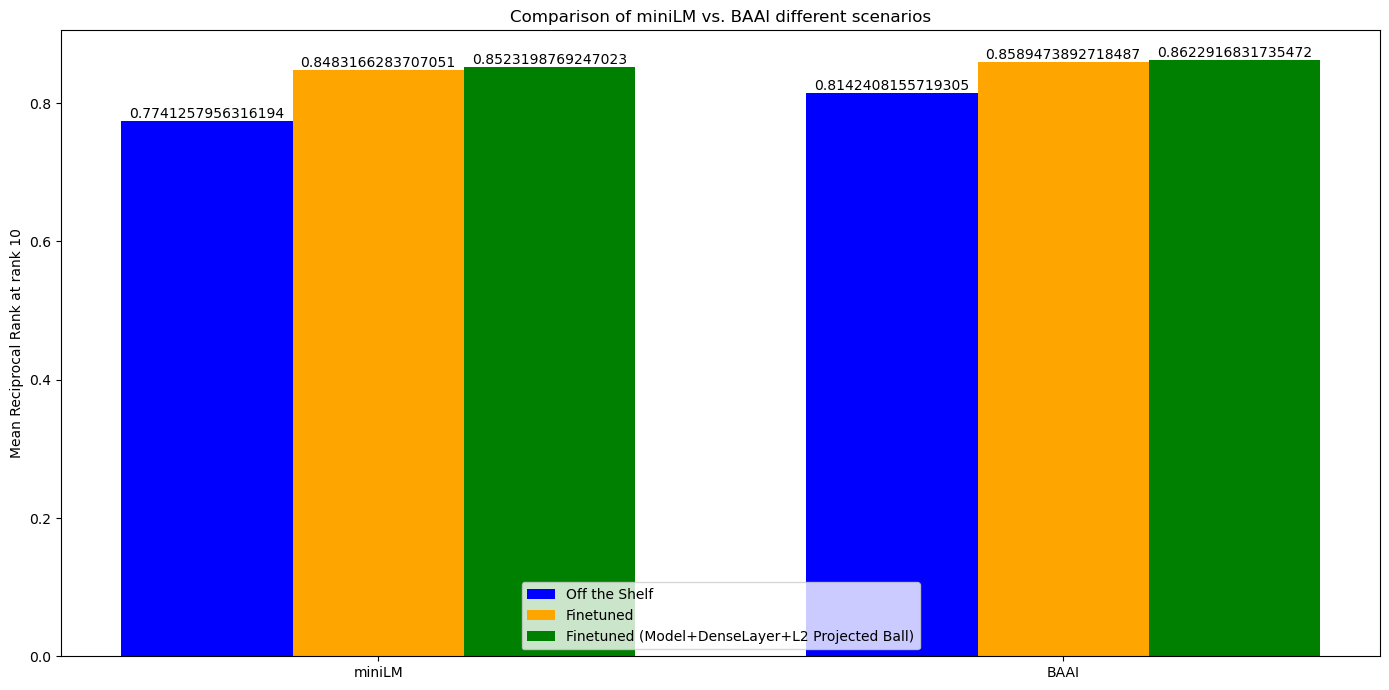

In [23]:
mini_shelf = results_minilm['dot_mrr@10']
mini_finetuned = results_minilm_finetuned['dot_mrr@10']
mini_projected = results_minilm_finetuned_projected['dot_mrr@10']

baai_shelf= results_baai['dot_mrr@10']
baai_finetuned = results_baai_finetuned['dot_mrr@10']
baai_projected = results_baai_finetuned_projected['dot_mrr@10']

models = ['miniLM', 'BAAI']
configurations = ['Off the Shelf', 'Finetuned', 'Finetuned (Model+DenseLayer+L2 Projected Ball)']

mini = [mini_shelf, mini_finetuned, mini_projected]
baai = [baai_shelf, baai_finetuned, baai_projected]


# Set up the bar width and positions
bar_width = 0.25
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]


plt.figure(figsize=(14, 7))

# Function to add value labels
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}',
                 ha='center', va='bottom')

# Create and label the bars for each configuration
bars1 = plt.bar(r1, [mini[0], baai[0]], color='blue', width=bar_width, label=configurations[0])
bars2 = plt.bar(r2, [mini[1], baai[1]], color='orange', width=bar_width, label=configurations[1])
bars3 = plt.bar(r3, [mini[2], baai[2]], color='green', width=bar_width, label=configurations[2])

# Add the value labels
add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

plt.xlabel('')
plt.ylabel('Mean Reciprocal Rank at rank 10')
plt.title('Comparison of miniLM vs. BAAI different scenarios')
plt.xticks([r + bar_width for r in range(len(models))], models)
plt.legend(loc='lower center')
plt.tight_layout()
plt.show()

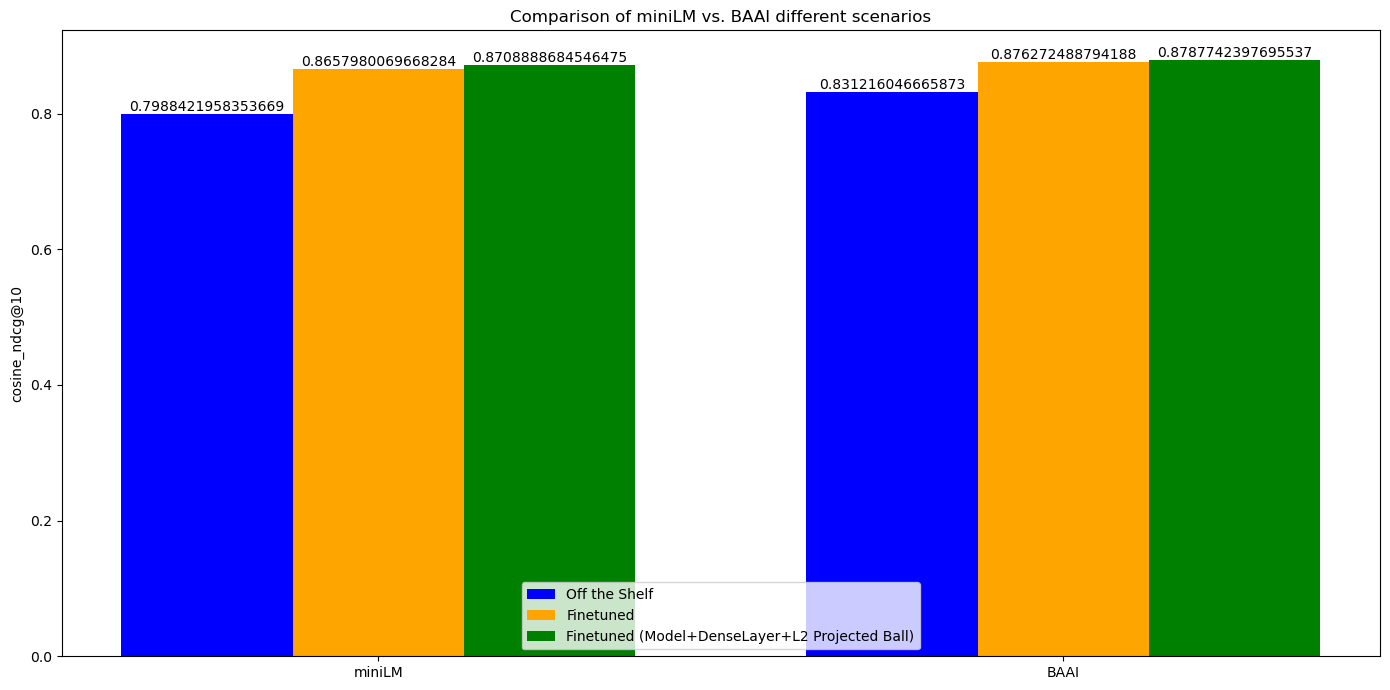

In [24]:
mini_shelf= results_minilm['cosine_ndcg@10']
mini_finetuned = results_minilm_finetuned['cosine_ndcg@10']
mini_projected = results_minilm_finetuned_projected['cosine_ndcg@10']

baai_shelf= results_baai['cosine_ndcg@10']
baai_finetuned = results_baai_finetuned['cosine_ndcg@10']
baai_projected = results_baai_finetuned_projected['cosine_ndcg@10']

models = ['miniLM', 'BAAI']
configurations = ['Off the Shelf', 'Finetuned', 'Finetuned (Model+DenseLayer+L2 Projected Ball)']

mini = [mini_shelf, mini_finetuned, mini_projected]
baai = [baai_shelf, baai_finetuned, baai_projected]


# Set up the bar width and positions
bar_width = 0.25
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]


plt.figure(figsize=(14, 7))

# Function to add value labels
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}',
                 ha='center', va='bottom')

# Create and label the bars for each configuration
bars1 = plt.bar(r1, [mini[0], baai[0]], color='blue', width=bar_width, label=configurations[0])
bars2 = plt.bar(r2, [mini[1], baai[1]], color='orange', width=bar_width, label=configurations[1])
bars3 = plt.bar(r3, [mini[2], baai[2]], color='green', width=bar_width, label=configurations[2])

# Add the value labels
add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

plt.xlabel('')
plt.ylabel('cosine_ndcg@10')
plt.title('Comparison of miniLM vs. BAAI different scenarios')
plt.xticks([r + bar_width for r in range(len(models))], models)
plt.legend(loc='lower center')
plt.tight_layout()
plt.show()

### Latency 
evaluating the speed of a retrieval system involves determining the time it takes to fetch relevant documents in response to a given query using an embedding model.

In [ ]:


def retrieve_item(model, question):
    start_time = time.time()
    outputs = model.encode(question)
    end_time = time.time()
    return (outputs, (end_time - start_time) * 1000)  # Return latency in milliseconds

def measure_latency(model, questions):
    latencies = []

    for question in questions:
        _, latency = retrieve_item(model, question)
        latencies.append(latency)
    
    return latencies

In [80]:
import time 

test_data = pd.read_csv("finetune_dataset/test_embedding.csv")
test_queries = test_data["Question"].tolist()


latencies_mini = measure_latency(model_minilm_finetuned_projected, test_queries)
latencies_baai = measure_latency(model_baai_finetuned_projected, test_queries)

average_latency_mini = np.mean(latencies_mini)
p95_latency_mini = np.percentile(latencies_mini, 95)
p99_latency_mini = np.percentile(latencies_mini, 99)

average_latency_baai = np.mean(latencies_baai)
p95_latency_baai = np.percentile(latencies_baai, 95)
p99_latency_baai = np.percentile(latencies_baai, 99)



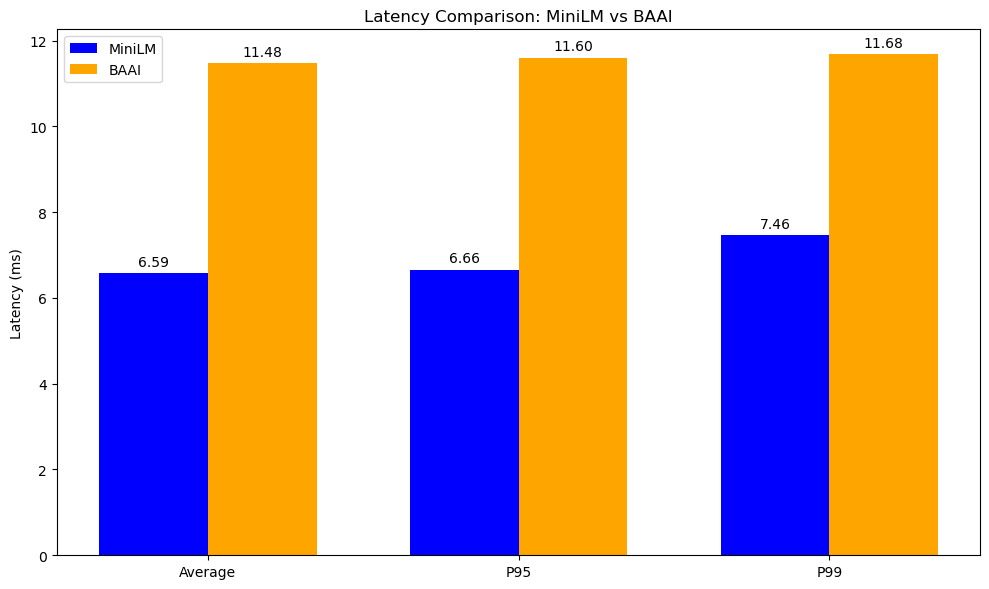

In [84]:
models = ['miniLM', 'BAAI']
metrics = ['Average', 'P95', 'P99']

minilm_values = [average_latency_mini, p95_latency_mini, p99_latency_mini]
baai_values = [average_latency_baai, p95_latency_baai, p99_latency_baai]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, minilm_values, width, label='MiniLM', color='blue')
rects2 = ax.bar(x + width/2, baai_values, width, label='BAAI', color='orange')

ax.set_ylabel('Latency (ms)')
ax.set_title('Latency Comparison: MiniLM vs BAAI')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')

fig.tight_layout()

plt.show()

Based on this latency plot and performance, it can be concluded that 